In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [3]:
train_df = pd.read_csv('골밀도 데이터/train_data.csv')
train_df = train_df[['No', '성별', 'boneage']]
train_df.columns = ['id', 'gender', 'boneage']
train_df['id'] = train_df['id'].astype('str')

mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()

train_df['boneage_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

train_df.head()

,id,gender,boneage,boneage_z
0,98.jpg,F,12.125,0.615059
1,1162.jpg,M,7.125,-0.634581
2,636.jpg,M,10.500,0.208926
3,990.jpg,M,4.125,-1.384365
4,618.jpg,M,9.625,-0.009761


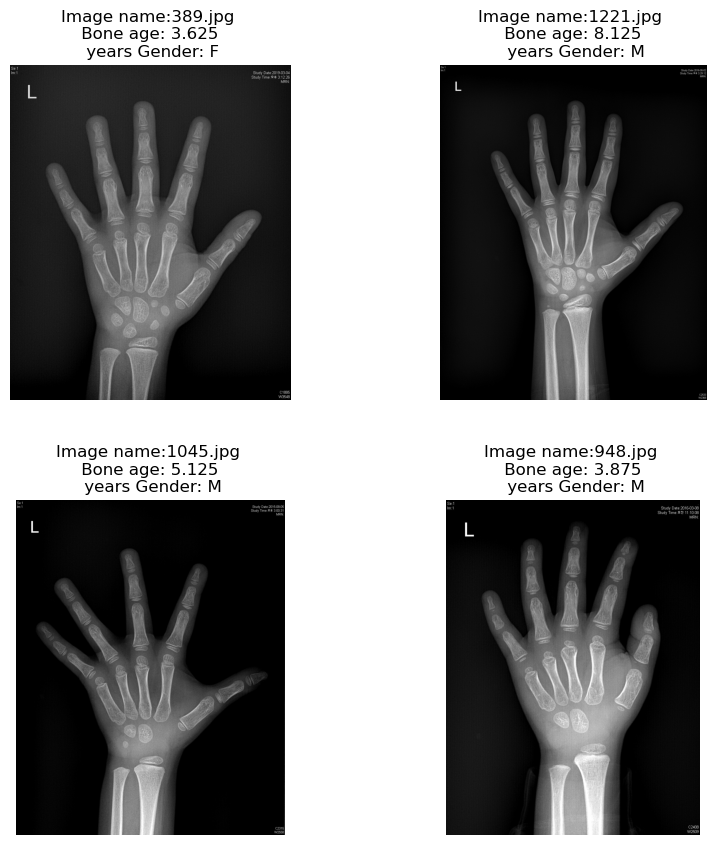

In [4]:
import matplotlib.image as mping
fig, axes = plt.subplots(2,2, figsize = (10, 10))
plt.subplots_adjust(hspace=0.3)
i = 0
for filename, boneage, gender in train_df[['id', 'boneage', 'gender']].sample(4).values:
    img = mping.imread('골밀도 데이터/train_image/' + str(filename))
    axes[i//2,i%2].imshow(img)
    axes[i//2,i%2].set_title('Image name:{} \n Bone age: {} \n years Gender: {}'.format(filename, boneage, gender))
    axes[i//2,i%2].axis('off')
    i += 1
    
plt.show()

## 2. 이미지 전처리

In [5]:
train_path = '골밀도 데이터/train_image/'
test_path = '골밀도 데이터/test_image/'

Grayscale

(1572, 1184)


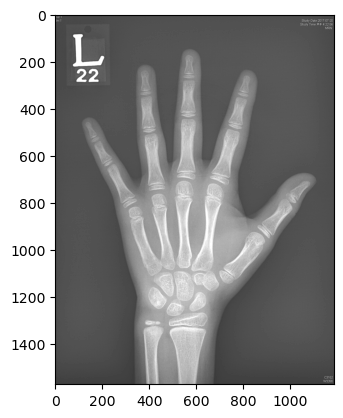

In [8]:
img = cv2.imread(train_path + '1.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, 'gray')
plt.show()

Resize

In [18]:
ratio = 0
for i in range(len(train_df.id)):
    img = cv2.imread(train_path + train_df['id'][i], cv2.IMREAD_GRAYSCALE)
    ratio += img.shape[0] / img.shape[1]

ratio / len(train_df.id)

1.2670239792012663

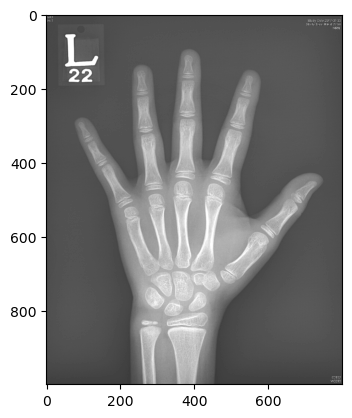

In [10]:
# 이미지 사이즈 재설정
resize_img = cv2.resize(img, (800, 1000))
plt.imshow(resize_img, 'gray')

Normalize

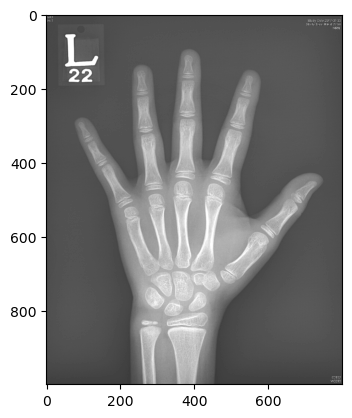

In [11]:
# 이미지 min max 정규화
normal_img = cv2.normalize(resize_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img, 'gray')

Denoise

In [ ]:
# denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 10, 5, 15)
# plt.imshow(denoise_img,"gray")

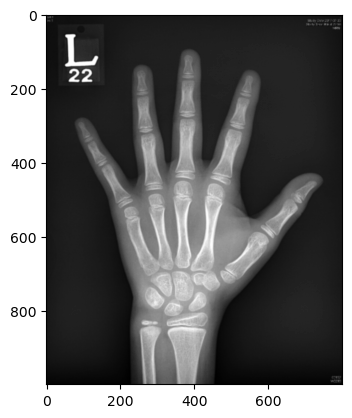

In [67]:
denoise_img = cv2.GaussianBlur(normal_img, (5, 5), 0)
plt.imshow(denoise_img,"gray")

Equalize

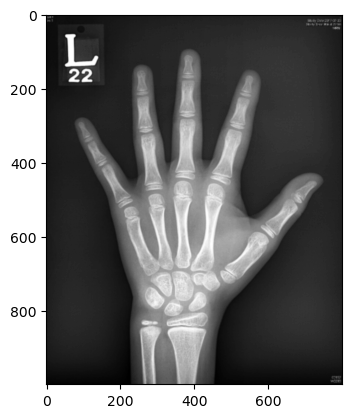

In [70]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img, 'gray')

In [10]:
pre_train_image_folder = '골밀도 데이터/pre_train_image/'
os.makedirs(pre_train_image_folder, exist_ok=True)

In [19]:
# fig, ax = plt.subplots(2,2, figsize = (10, 10))
for i in range(0, train_df.shape[0]):
    img_path = glob.glob(train_path + train_df.id[i])[0]
    
    img_name = img_path.split('/')[-1]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 이미지 사이즈 재설정
    resized_img = cv2.resize(img, (800, 1000))
    # ax[0,0].imshow(resized_img, 'gray')
    
    # 이미지 정규화
    normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    # ax[0,1].imshow(normal_img, 'gray')
    
    # 이미지 노이즈 제거
    denoise_img = cv2.GaussianBlur(normal_img, (5, 5), 0)
    # ax[1,0].imshow(denoise_img, 'gray')
    
    # 이미지 평탄화
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    equal_img=clahe.apply(denoise_img)
    # ax[1,1].imshow(equal_img, 'gray')
    
    # 이미지 저장
    cv2.imwrite(pre_train_image_folder + img_name, equal_img)

## 3. 이미지 회전
+ 여기서부터 시작

In [16]:
data = pd.read_csv('골밀도 데이터/train_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


### 샘플이미지 회전

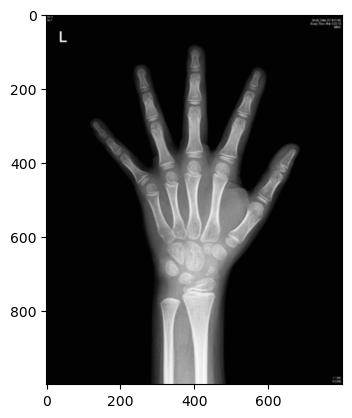

In [120]:
temp_img = cv2.imread('골밀도 데이터/pre_train_image/1227.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(temp_img, 'gray')

샘플이미지 Thresholding
+ 0 ~ 255 사이로

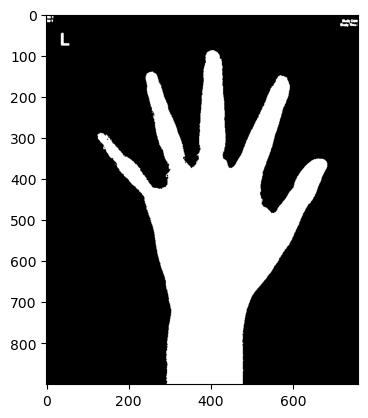

In [121]:
r_img = np.copy(temp_img)
height, width = temp_img.shape
img = temp_img[0:(int)(height*0.9),0:(int)(width*0.95)]

# 픽셀 값의 평균 크면 255로 설정되고 작으면 0으로 설정정
ret, img = cv2.threshold(img, temp_img.mean(), 255, cv2.THRESH_BINARY)

#샘플 이미지 Thresholding 결과
plt.imshow(img,"gray")

### 이미지 contouring

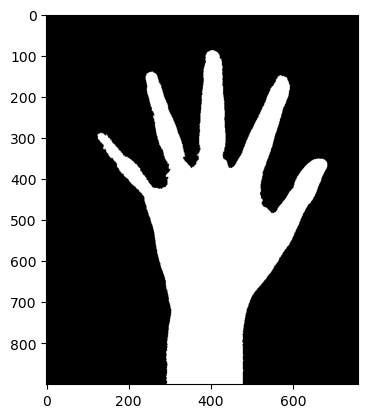

In [122]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#외곽선 검출하여 mask 그리기
max_cnt = max(contours, key=cv2.contourArea)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

plt.imshow(mask, 'gray')

### 첫 번째 흰색 좌표 구하기
+ 첫 번째 흰색 좌표가 중지 끝임

In [123]:
M = cv2.moments(max_cnt)
center = (int(M['m10']/M['m00']), int(M['m01']/M['m00']))

for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[len(x_255_indexs)//2]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break
        
print((first_255_x_point,first_255_y_point))
        

(404, 88)


### 무게중심과 좌표의 각도 구하여 회전

In [17]:
# 이미지 회전 함수 정의
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

In [127]:
# 무게중심과 첫 흰색 좌표 차이
center_x, center_y = center[0], center[1]
rx = abs(first_255_x_point - center_x)
ry = center_y - first_255_y_point

# 회전 각도 구하기
import math
radian = math.atan2(ry, rx)
degree = 90 - math.degrees(radian)

# 무게중심과 첫 좌표 위치에 따라 회전 방향 조정

if first_255_x_point < center_x :
    mask = rotate_image(mask,360-degree) 
    r_img_ = rotate_image(temp_img,360-degree)
else:
    mask = rotate_image(mask,degree) 
    r_img_ = rotate_image(temp_img,degree) 

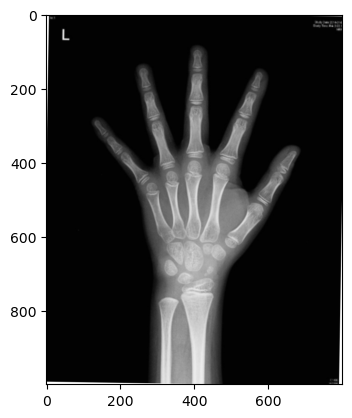

In [128]:
plt.imshow(r_img_, 'gray')

### 전체 이미지 회전

In [15]:
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


In [18]:
rotate_path = '골밀도 데이터/rotate_image/'
os.makedirs(rotate_path, exist_ok=True)

In [ ]:
for i in range(len(data)):
    img0 = cv2.imread('골밀도 데이터/pre_train_image/'+data.No[i], cv2.IMREAD_GRAYSCALE)
    rotate_image_path = '골밀도 데이터/rotate_image/' + data.No[i]
    
    # 이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)
    
    # 이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key = cv2.contourArea)
    mask = np.zeros(img.shape, dtype= np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)
    
    # 이진화 이미지에서 1차 모멘트 구하기
    M = cv2.moments(max_cnt)
    center = (int(M['m10']/M['m00']), int(M['m01']/M['m00']))
    
    # 중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[len(x_255_indexs)//2]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
        
    # 중심점의 좌표 기준 첫 흰색 죄표와 차이 구하기
    center_x, center_y = center[0], center[1]
    rx = abs(first_255_x_point - center_x)
    ry = center_y - first_255_y_point

    # 회전 각도 구하기
    import math
    radian = math.atan2(ry, rx)
    degree = 90 - math.degrees(radian)

    # 무게중심과 첫 좌표 위치에 따라 회전 방향 조정

    if first_255_x_point < center_x :
        mask = rotate_image(mask, 360-degree) 
        r_img_ = rotate_image(img0, 360-degree)
    else:
        mask = rotate_image(mask, degree) 
        r_img_ = rotate_image(img0, degree) 
    
    # 이미지 저장
    cv2.imwrite(rotate_image_path, r_img)

## 4. ROI 추출

In [3]:
data = pd.read_csv('골밀도 데이터/train_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


### ROI 추출 위한 함수 정의

이미지를 roi에 따라 자르는 함수

In [ ]:
def crop_img(img, roi_1, roi_2, roi_3, roi_4, roi_5):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]]
    cropped_roi_4_img = img[roi_4[0][1]:roi_4[1][1],roi_4[0][0]:roi_4[1][0]]
    cropped_roi_5_img = img[roi_5[0][1]:roi_5[1][1],roi_5[0][0]:roi_5[1][0]]
    
    optimzed_imgs = optimze_img(cropped_roi_1_img,cropped_roi_2_img,cropped_roi_3_img,cropped_roi_4_img,cropped_roi_5_img)
    return optimzed_imgs

ROI 이미지 2차 전처리 함수

In [ ]:
def optimze_img(r1,r2,r3,r4,r5):
  
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    try : 
        for _,img in enumerate([r1,r2,r3,r4,r5]):
            if img is not None:
                
                resized_img = cv2.resize(img,(256,256))
                blured_img = cv2.GaussianBlur(resized_img,(5,5),0)

                if len(blured_img.shape) == 3:
                    blured_img = blured_img[:,:,0]
                else:
                    blured_img = blured_img
                

                clahed_img = clahe.apply(blured_img)          #CLAHE 적용


                _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
                
                tmp_binary_img.append(binary_img)
                
        
    except:
        tmp_binary_img = []
    return np.array(tmp_binary_img)

ROI 좌표로 iou를 구하는 함수

In [ ]:
def get_iou(roi_points,iou_points):
    iou_cor,iou_four,iou_mid = 0,0,0
    
    intersection_cor_x = min(roi_points[0][1][0],iou_points[0][1][0])- max(roi_points[0][0][0],iou_points[0][0][0])
    intersection_cor_y = min(roi_points[0][1][1],iou_points[0][1][1])- max(roi_points[0][0][1],iou_points[0][0][1])
    
    cor_area = (roi_points[0][1][0] - roi_points[0][0][0]) * (roi_points[0][1][1] - roi_points[0][0][1]) + (iou_points[0][1][0] - iou_points[0][0][0]) * (iou_points[0][1][1] - iou_points[0][0][1])
    intersection_cor_area = intersection_cor_x * intersection_cor_y
    
    intersection_four_x = min(roi_points[1][1][0],iou_points[1][1][0])- max(roi_points[1][0][0],iou_points[1][0][0])
    intersection_four_y = min(roi_points[1][1][1],iou_points[1][1][1])- max(roi_points[1][0][1],iou_points[1][0][1])
    
    four_area = (roi_points[1][1][0] - roi_points[1][0][0]) * (roi_points[1][1][1] - roi_points[1][0][1]) + (iou_points[1][1][0] - iou_points[1][0][0]) * (iou_points[1][1][1] - iou_points[1][0][1])
    intersection_four_area = intersection_four_x*intersection_four_y
    
    intersection_mid_x = min(roi_points[2][1][0],iou_points[2][1][0])- max(roi_points[2][0][0],iou_points[2][0][0])
    intersection_mid_y = min(roi_points[2][1][1],iou_points[2][1][1])- max(roi_points[2][0][1],iou_points[2][0][1])
    
    mid_area = (roi_points[2][1][0] - roi_points[2][0][0]) * (roi_points[2][1][1] - roi_points[2][0][1]) + (iou_points[2][1][0] - iou_points[2][0][0]) * (iou_points[2][1][1] - iou_points[2][0][1])
    intersection_mid_area = intersection_mid_x*intersection_mid_y
    
    if intersection_cor_area > 0 and intersection_four_area >0 and intersection_mid_area>0:
        iou_cor = intersection_cor_area / (cor_area - intersection_cor_area)
        iou_four = intersection_four_area / (four_area-intersection_four_area)
        iou_mid = intersection_mid_area / (mid_area - intersection_mid_area)
    
    return iou_cor,iou_four,iou_mid

### 샘플이미지 ROI 추출
+ 샘플 이미지 로드 및 이진화

In [59]:
img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[0], cv2.IMREAD_GRAYSCALE)
# plt.imshow(img0, 'gray')

# 이미지 thresholding
r_img = np.copy(img0)
height, width = img0.shape
img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

# 이미지 contouring
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key = cv2.contourArea)
mask = np.zeros(img.shape, dtype= np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

오목한 좌표와 볼록한 좌표 구하기

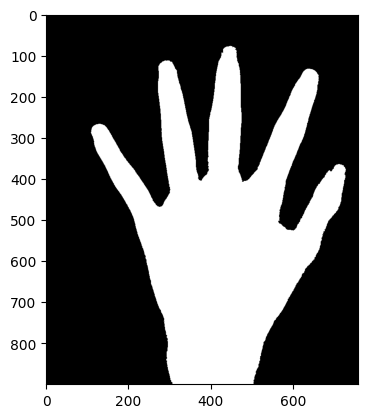

In [60]:
plt.imshow(mask, 'gray')

In [61]:
#좌표 저장공간 설정(첫번째 공간에는 무게중심점, 두번째 공간에는 start점, 세번째에는 far점) 
dots = [[],[],[]]

# 이진화 이미지에서 1차 모멘트 구하기
M = cv2.moments(max_cnt) 
center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
dots[0].append(center)

# 볼록한 점 구하기
hull = cv2.convexHull(max_cnt, returnPoints= False)
hull1 = cv2.convexHull(max_cnt)
hull1.shape

(28, 1, 2)

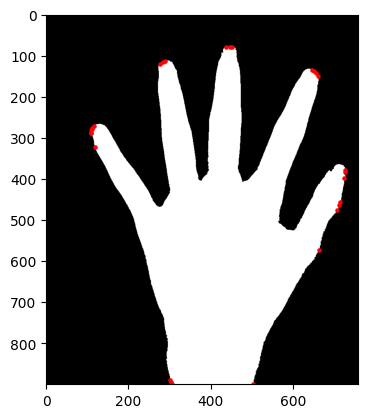

In [62]:
plt.imshow(mask, 'gray')
for grid in hull1:
    x, y = grid[0]
    plt.scatter([x], [y], c = 'red', marker = 'o', s = 5)

plt.show()

In [63]:
# 오목한 지점 구하기
defects = cv2.convexityDefects(max_cnt, hull)

# 거리를 저장할 수 있는 공간 생성
di = []

for index in range(defects.shape[0]):
    # 시작점, 끝점, far 점, 거리 할당
    sp, ep, fp, distance = defects[index, 0]
    
    far = tuple(max_cnt[fp][0])
    start = tuple(max_cnt[sp][0])
    end = tuple(max_cnt[ep][0])
    
    # 거리 저장
    di.append(distance)
    dots[1].append(start)
    dots[2].append(far)

In [ ]:
# start, far로 분리
start_pt = np.array(dots[1])
far_pt = np.array(dots[2])

far_xrange = []
far_yrange = []
far_miny = 1000
far_maxy = 0
start_miny = 1000

# 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
di = np.array(di)
s_di = np.sort(di)[::-1]
# s_di

# 내림차순된 거리들을 6개만 뽑아내기 위해 slice
for i in list(s_di[:6]):
    index = np.where(di == i)[0]
    
    # 6개의 좌표들 중에서 가장 최저의 y 값을 찾는다.
    far_miny = min(far_miny, far_pt[index[0]][1])
    
    # 6개의 좌표들 중에서 가장 최고의 y 값을 찾는다.
    far_maxy = max(far_maxy, far_pt[index[0]][1])
    
    # 가장 오목한 지점 6개의 좌표를 출력
    cv2.circle(img, np.array(far_pt[index[0]]), 2, [255, 255, 255], 5)
    
    # 좌표들이 x, y로 나눠져 있어서 쉽게 비교하기 위해 x, y끼리 나누자.
    far_xrange.append(far_pt[index[0]][0])
    far_yrange.append(far_pt[index[0]][1])
    
# far_xrange 를 오름차순으로 정렬
sorted_far_xrange = np.sort(far_xrange)
sorted_far_yrange = np.sort(far_yrange)

### 손목뼈 좌표 추출

손목 관절 roi 좌표 


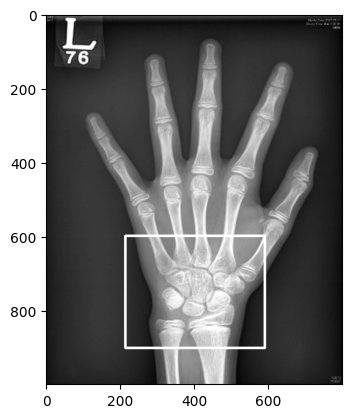

In [91]:
#손목뼈 ROI
carpus_start_point = ((int)(np.sort(far_xrange)[0]),(int)(center[1]*1.15))
carpus_end_point = (int(np.sort(far_xrange)[-1]*1.05),(int)(far_maxy*1.15))

#손목뼈 부분 roi 를 하기 위해서는 가장 오목하게 들어가 있는 부분중에서 가장 최저 x값(xrange[0])과 center값의 y값을 시작점으로
#끝점으로는 가장 오목하게 들어가 있는 부분들 중에서 가장 최고 x값(xrange[-1])과 오목하게 들어간 점중에서 가장 최고 y값을 준다.
carpus=cv2.rectangle(np.copy(img0),carpus_start_point,carpus_end_point,[255,255,255],5)

#ROI 확인
print("손목 관절 roi 좌표 ")
plt.imshow(carpus,"gray")

### 손목뼈 위쪽 관절 추출

가운데 4개 관절 roi 좌표


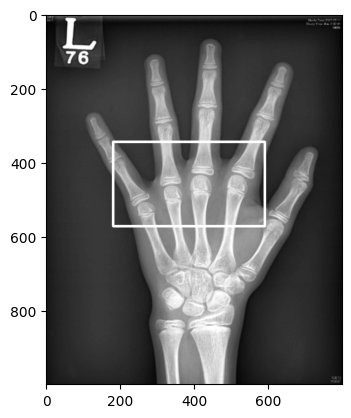

In [93]:
#손목뼈 위쪽에 있는 관절 4개를 추출
#오목하게 들어가 있는 부분중에서 가장 최저 x값(xrange[0])과 far_miny 값을 y값으로
#끝점으로는 가장 오목하게 들어가 있는 부분들 중에서 가장 최고 x값(xrange[-1])과 center의 y값을 준다.

four_start_point = ((int)(np.sort(far_xrange)[0]*0.85),int(far_miny*0.85))
four_end_point = (int(np.sort(far_xrange)[-1]*1.05),(int)(center[1]*1.1))

finger4=cv2.rectangle(np.copy(img0),four_start_point,four_end_point,[255,255,255],5)

#ROI 확인
print("가운데 4개 관절 roi 좌표")
plt.imshow(finger4,"gray")

### 중지 좌표 추출

중지 roi 좌표


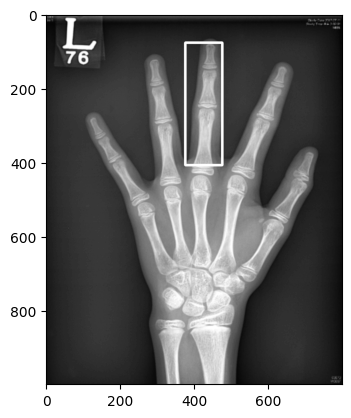

In [94]:
#중지 ROI 추출
#중지를 추출하기 위해서 start_pt의 x 좌표가 sorted_far_xrange 에서 3번째와 4번째 값 사이에 있어야 한다.
middle_index = np.where((start_pt[:,0]<=(int)(sorted_far_xrange[3])) & (start_pt[:,0]>=sorted_far_xrange[2]))[0]

#위에 조건식으로 나온 인덱스를 start_point에 대입하면 만족하는 좌표들이 여러개 나올것이다.
middle_points = start_pt[middle_index]


for point in middle_points:
    #가운데 손가락 사이에 있는 좌표들 중에서 최저 y 값을 찾는다.
    start_miny = min(start_miny,point[1])


start_maxy = max(far_yrange[np.where(far_xrange == sorted_far_xrange[3])[0][0]],far_yrange[np.where(far_xrange == sorted_far_xrange[2])[0][0]])
#시작 좌표로는 x값으로 sorted_far_xrange 에서 3번째와 y 값으로는 최저y 값을 주고 
#마지막 좌표로는 x값으로 sorted_far_xrange 에서 4번째와 y값으로는 3번째 와 4번째 좌표의 최고 y 값을 준다.
middle_finger_start_point = (sorted_far_xrange[2],start_miny)
middle_finger_end_point = (sorted_far_xrange[3],start_maxy)

finger3=cv2.rectangle(np.copy(img0),middle_finger_start_point,middle_finger_end_point,[255,255,255],5)

#ROI 확인
print("중지 roi 좌표")
plt.imshow(finger3,"gray")